### 1. 自回归模型
- 即对见过的数据建模，autoregressive models(AR)  
$$ p(x_t|x1,...,x_{t-1})=p(x_t|f(x_1,...,x_{t-1})) \tag{1}$$  
- 核心在于怎么得到此处的$f$  
- 然后进一步在于怎么得到$p$

#### 方案A-马尔可夫假设
- 假设当前数据只与$\tau$个过去数据点相关
- (0318天气预报的方案即与此处类似，那里的$\tau=3$)
- 每预测一个新的数据，只需要看过去$\tau$个
- $\tau$的选择可以是任意的，如果选取较大，那么模型就会复杂一些
- 这样的优点是，我们并不需要去关注 **很久之前** 的数据，例如说是股票预测，对于很多天之前的数据，我们可能就并不是非常关心了
- 那么，公式$(1)$即可以改写为：
$$p(x_t|x1,...,x_{t-1})=p(x_t|x_{t-\tau},...,x_{t-1})=p(x_t|f(x_{t-\tau},...,x_{t-1})) \tag{2}$$

#### 方案B-潜变量模型
- 引入潜变量$h_t$来表示过去信息$h_t=f(x_1,...,x_t-1)$
- 这样$x_t=p(x_t|h_t)$  
- 如下图所示，$h_{t-1}$与$x_{t-1}$通过模型1，得到$h_t$，然后$h_t$与$x_{t-1}$通过模型2，得到$x_t$，这样的话可以使得每一个模型，都只与1个或2个变量相关，从而更加容易计算
<center>

![alt text](https://zh.d2l.ai/_images/sequence-model.svg)

</center>

#### 总结
- 时序模型中，当前数据与之前观察到的数据相关(**时间上是相关的**)
- **自回归模型** 使用自身过去数据来预测未来
    - **马尔可夫模型** 假设当前只跟最近少数数据相关
    - **潜变量模型** 使用潜变量 来概括历史信息，例如RNN

#### Code:
##### 马尔可夫假设
- 使用正弦函数和一些可加性噪声来生成序列数据，时间步为1,2,...,1000

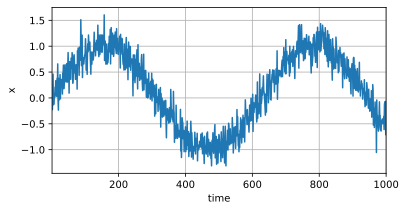

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

- 将数据映射为数据对$y_t=x_t$和$\pmb{x}_t=[x_{t-\tau},...,x_{t-1}]$
- $y_t$表示第$t$时刻数据的预测值，用于预测的$\pmb{x}_t$由其前面的$\tau$个数据得到
- `T-tau`是样本数，`tau`是特征数，
- `features`表示样本特征，共有`T-tau`行，`tau`列，即由长度为`tau`的滑窗“提取”到的数据上下拼接而成
- `for`循环用于实现：依次获取每个滑窗中的数据
- 将时序序列，通过马尔可夫假设，转化为了一个 **回归**问题

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

- 采用一个相当简单的结构，即一个拥有两个全连接层的多层感知机
- `net`是一个输入维数为4，隐藏层为10的线性层，然后加上一个`RELU`，最后输出为1层的点，因为是转化为了回归问题，所以输出的是一个标量
- 同样因为是一个回归问题，所以此处采用`MSE`作为损失函数

In [3]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

训练模型
- 此处采用`Adam`优化器(分类器)

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.062389
epoch 2, loss: 0.056567
epoch 3, loss: 0.053262
epoch 4, loss: 0.051277
epoch 5, loss: 0.052519


单步预测
- 模型预测下一个时间步
- 检查模型预测下一个时间步的能力， 也就是单步预测（one-step-ahead prediction）
- 即用597，598，599，600的观测值预测得到601，此处单步预测则是接着采用598，599，600，601的观测值(注意此处601用的是观测值，而不是刚刚得到的601的预测值)来预测602
- 以此类推

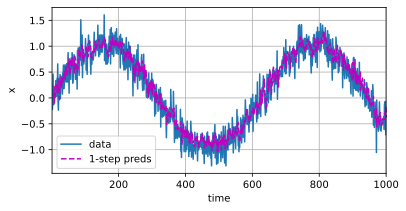

In [5]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

多步预测
- 相较于上面的单步预测，此处只对601~1000进行验证，先采用600，601，602，603的**观测值**来预测得到604，接着采用601，602，603的观测值和**604的预测值**来预测605
- 也就是说，从604，605，606，607预测608开始，参与预测的数据均是预测值，而非此前onestep中的观测值了
- 而预测值存在误差，这就使得随着预测的推进，会不断**累积误差**，导致了如图中`multistep preds`，也就是绿色线中的情况，无法进行较为准确的预测
- tips: 在python的numpy库中，`reshape()`函数用于改变数组的形状，`reshape((1, -1))`表示 将数组重塑为一行，列数不限。其中`-1`为一个特殊值，表示“自动计算”

- 单步预测 其实就属于 短期预测，即只预测了一个时间步
- 而多步预测 则属于 长期预测，显然只用$\tau$个数据，来预测很远的未来，是一件很难的事情

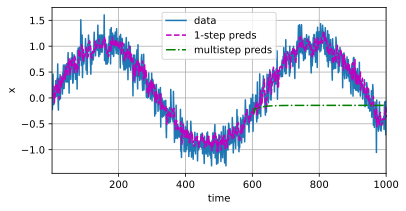

In [10]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

k步预测
- 其实上面的多步预测对应的k=400，即预测了第600个数据以后的400步
- k步预测可以理解为 基于$\tau$个观测点，去预测$k$个点

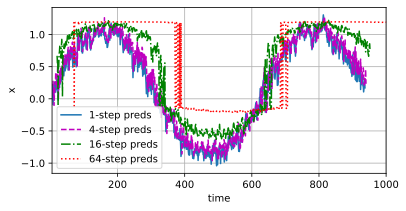

In [7]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

总结
- 基于Markov假设，将一个时序序列转化为一个简单的MLP做自回归
- 通过观察多步预测的结果，可以发现：显然只用$\tau$个数据，来预测很远的未来，即进行长期预测，是一件很难的事情
- 那么 后续时序模型的提出，有一部分就是希望 能够尽可能地预测 更远的未来